In [55]:
import numpy as np 
import pandas as pd 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder, PowerTransformer,MinMaxScaler
from sklearn.model_selection import train_test_split

In [56]:
import dagshub
dagshub.init(repo_owner='vinayak910', repo_name='swiggy-delivery-time-prediction', mlflow=True)

Initialized MLflow to track repo "vinayak910/swiggy-delivery-time-prediction"

Repository vinayak910/swiggy-delivery-time-prediction initialized!

In [57]:
import mlflow
mlflow.set_tracking_uri("https://dagshub.com/vinayak910/swiggy-delivery-time-prediction.mlflow")

In [58]:
from sklearn import set_config

set_config(transform_output="pandas")

In [59]:
df = pd.read_csv("swiggy_cleaned.csv")

In [60]:
df.columns

Index(['rider_id', 'age', 'ratings', 'restaurant_latitude',
       'restaurant_longitude', 'delivery_latitude', 'delivery_longitude',
       'order_date', 'weather', 'traffic', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city_type', 'time_taken', 'city_name', 'order_day', 'order_month',
       'order_day_of_week', 'is_weekend', 'pickup_time_minutes',
       'order_time_hour', 'order_time_of_day', 'distance', 'distance_type'],
      dtype='object')

In [61]:
df.drop(columns = ['rider_id',
                    'restaurant_latitude',
                    'restaurant_longitude',
                    'delivery_latitude',
                    'delivery_longitude',
                    'order_date',
                    "order_time_hour",
                    "order_day",
                    "city_name",
                    "order_day_of_week",
                    "order_month"]
                    , inplace= True)

In [62]:
df.columns

Index(['age', 'ratings', 'weather', 'traffic', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city_type', 'time_taken', 'is_weekend', 'pickup_time_minutes',
       'order_time_of_day', 'distance', 'distance_type'],
      dtype='object')

In [63]:
import missingno as msno 

<Axes: >

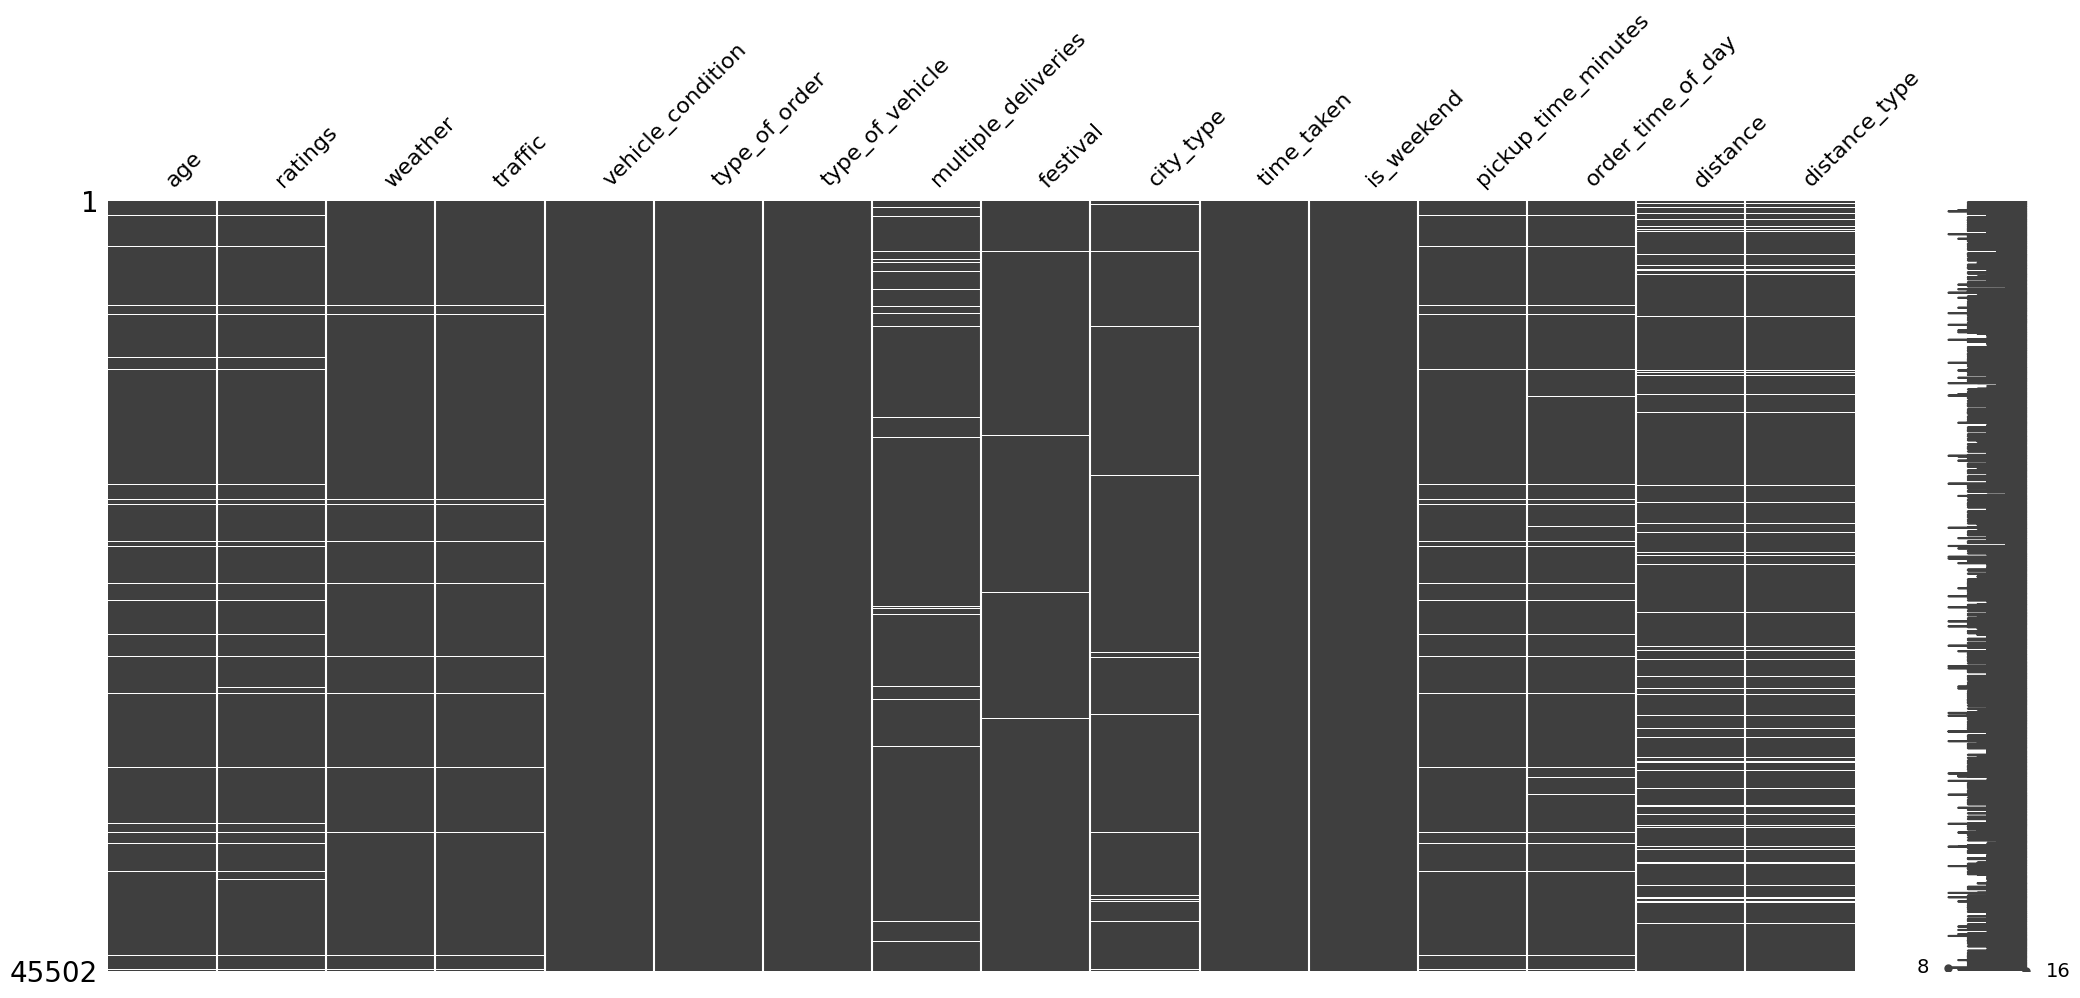

In [64]:
msno.matrix(df)

In [65]:
missing_cols = (df
                .isna()
                .any(axis = 0)
                .loc[lambda x : x]
                .index)

In [66]:
missing_cols

Index(['age', 'ratings', 'weather', 'traffic', 'multiple_deliveries',
       'festival', 'city_type', 'pickup_time_minutes', 'order_time_of_day',
       'distance', 'distance_type'],
      dtype='object')

In [67]:
temp_df = df.copy().dropna()

In [68]:
X = temp_df.drop(columns= 'time_taken')
y = temp_df['time_taken']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
X_train.isna().sum()

age                    0
ratings                0
weather                0
traffic                0
vehicle_condition      0
type_of_order          0
type_of_vehicle        0
multiple_deliveries    0
festival               0
city_type              0
is_weekend             0
pickup_time_minutes    0
order_time_of_day      0
distance               0
distance_type          0
dtype: int64

In [71]:
X_train.shape , X_test.shape

((30156, 15), (7539, 15))

In [72]:
pt = PowerTransformer()

y_train_pt = pt.fit_transform(y_train.values.reshape(-1 , 1))

y_test_pt = pt.transform(y_test.values.reshape(-1 , 1))

In [73]:
y_train_pt.shape

(30156, 1)

In [74]:
y_test_pt.shape

(7539, 1)

In [75]:
X_train.columns

Index(['age', 'ratings', 'weather', 'traffic', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city_type', 'is_weekend', 'pickup_time_minutes', 'order_time_of_day',
       'distance', 'distance_type'],
      dtype='object')

In [76]:
num_cols= ['age','ratings','pickup_time_minutes','distance']

nom_cat_cols = ['weather', 'type_of_order',
                'type_of_vehicle',
                'festival',
                'city_type',
                'is_weekend','order_time_of_day',
                ]

ord_cat_cols = ['traffic', 'distance_type']

In [77]:
for col in ord_cat_cols:
    print(col , X_train[col].unique())

traffic ['jam' 'medium' 'high' 'low']
distance_type ['medium' 'short' 'long' 'very_long']


In [78]:
traffic_order = ['low', 'medium', 'high', 'jam']

distance_type_order = ['short', 'medium', 'long', 'very_long']

In [79]:
preprocessor = ColumnTransformer(
    transformers=[
        ('scale', MinMaxScaler(),num_cols),

        ('ordinal_encode', OrdinalEncoder(
            categories=[traffic_order,distance_type_order],
            encoded_missing_value= -999,
            handle_unknown="use_encoded_value",
            unknown_value= -1
        ), ord_cat_cols),

        ('nominal_encode',OneHotEncoder(
            handle_unknown= 'ignore',
            sparse_output= False
        ) , nom_cat_cols)
    ],remainder= "passthrough", n_jobs=-1, verbose_feature_names_out=False,
    force_int_remainder_cols = False

)

preprocessor

ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                  remainder='passthrough',
                  transformers=[('scale', MinMaxScaler(),
                                 ['age', 'ratings', 'pickup_time_minutes',
                                  'distance']),
                                ('ordinal_encode',
                                 OrdinalEncoder(categories=[['low', 'medium',
                                                             'high', 'jam'],
                                                            ['short', 'medium',
                                                             'long',
                                                             'very_long']],
                                                encoded_missing_value=-999,
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['traffic', 'distance_type']),
                                ('nominal_encode',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['weather', 'type_of_order', 'type_of_vehicle',
                                  'festival', 'city_type', 'is_weekend',
                                  'order_time_of_day'])],
                  verbose_feature_names_out=False)

In [80]:
X_train_processed = preprocessor.fit_transform(X_train)

X_test_processed = preprocessor.transform(X_test)

In [81]:
X_train_processed.shape

(30156, 32)

In [82]:
X_test_processed.shape 

(7539, 32)

In [83]:
X_train_processed.columns

Index(['age', 'ratings', 'pickup_time_minutes', 'distance', 'traffic',
       'distance_type', 'weather_cloudy', 'weather_fog', 'weather_sandstorms',
       'weather_stormy', 'weather_sunny', 'weather_windy',
       'type_of_order_buffet', 'type_of_order_drinks', 'type_of_order_meal',
       'type_of_order_snack', 'type_of_vehicle_electric_scooter',
       'type_of_vehicle_motorcycle', 'type_of_vehicle_scooter', 'festival_no',
       'festival_yes', 'city_type_metropolitian', 'city_type_semi-urban',
       'city_type_urban', 'is_weekend_0', 'is_weekend_1',
       'order_time_of_day_afternoon', 'order_time_of_day_evening',
       'order_time_of_day_morning', 'order_time_of_day_night',
       'vehicle_condition', 'multiple_deliveries'],
      dtype='object')

In [84]:
X_train 

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
8708,29.0,3.9,sunny,jam,0,drinks,motorcycle,2.0,no,semi-urban,0,15.0,night,9.348069,medium
25198,39.0,4.4,sandstorms,medium,0,meal,motorcycle,1.0,no,metropolitian,1,5.0,afternoon,4.469606,short
34049,29.0,4.5,sunny,high,1,buffet,motorcycle,0.0,no,urban,0,10.0,morning,1.513073,short
25987,39.0,4.8,sandstorms,low,0,meal,motorcycle,1.0,no,metropolitian,1,15.0,night,10.445118,long
37121,30.0,4.4,windy,medium,1,buffet,scooter,1.0,no,metropolitian,1,10.0,afternoon,6.217834,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20239,31.0,4.8,sunny,jam,0,meal,motorcycle,0.0,no,metropolitian,1,10.0,evening,10.279024,long
7590,21.0,5.0,sandstorms,medium,1,snack,motorcycle,1.0,no,metropolitian,1,15.0,evening,13.407034,long
13610,30.0,4.8,cloudy,medium,1,snack,motorcycle,0.0,no,metropolitian,1,5.0,afternoon,7.762606,medium
1045,38.0,4.9,sunny,low,0,buffet,motorcycle,1.0,no,urban,1,10.0,morning,1.552561,short


In [33]:
from lightgbm import LGBMRegressor
import optuna 

In [34]:
lgbm_params = {'n_estimators': 200,
 'learning_rate': 0.03195558234416709,
 'max_depth': 15,
 'num_leaves': 84}

In [35]:
lgbm = LGBMRegressor(**lgbm_params)

lgbm.fit(X_train_processed,y_train_pt.values.ravel())

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 32
[LightGBM] [Info] Start training from score -0.000000


LGBMRegressor(learning_rate=0.03195558234416709, max_depth=15, n_estimators=200,
              num_leaves=84)

In [36]:
y_pred_train = lgbm.predict(X_train_processed)
y_pred_test = lgbm.predict(X_test_processed)

In [37]:
y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1,1))

In [38]:
from sklearn.metrics import mean_absolute_error, r2_score

print(f"The train error is {mean_absolute_error(y_train,y_pred_train_org):.2f} minutes")
print(f"The test error is {mean_absolute_error(y_test,y_pred_test_org):.2f} minutes")

The train error is 2.81 minutes
The test error is 2.96 minutes


In [39]:
print(f"The train r2 score is {r2_score(y_train,y_pred_train_org):.2f}")
print(f"The test r2 score is {r2_score(y_test,y_pred_test_org)}")

The train r2 score is 0.86
The test r2 score is 0.8433906328750047


In [40]:
from sklearn.model_selection import cross_val_score
from sklearn.compose import TransformedTargetRegressor

In [43]:
mlflow.set_experiment("LGBM_HP_TUNING")


2025/07/14 15:08:08 INFO mlflow.tracking.fluent: Experiment with name 'LGBM_HP_TUNING' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/ce5bc01cb78f456aaa1e1a2ca55539ef', creation_time=1752485886419, experiment_id='7', last_update_time=1752485886419, lifecycle_stage='active', name='LGBM_HP_TUNING', tags={}>

In [44]:
def objective(trial):
    with mlflow.start_run(nested=True):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 300, step=10),
            "max_depth": trial.suggest_int("max_depth", 3, 15),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 15, 100),
            "n_jobs": -1,
            "random_state": 42
        }

        mlflow.log_params(params)

        # Wrap LGBMRegressor with target transformer
        base_model = LGBMRegressor(**params)
        model = TransformedTargetRegressor(regressor=base_model, transformer=pt)

        # Fit
        model.fit(X_train_processed, y_train)

        # Cross-validation
        cv_score = cross_val_score(
            model,
            X_train_processed,
            y_train,
            cv=5,
            scoring="neg_mean_absolute_error",
            n_jobs=-1
        )
        mean_cv_mae = -cv_score.mean()
        mlflow.log_metric("cross_val_error", mean_cv_mae)

        # Predict
        y_pred_train = model.predict(X_train_processed)
        y_pred_test = model.predict(X_test_processed)

        # Evaluate
        train_mae = mean_absolute_error(y_train, y_pred_train)
        test_mae = mean_absolute_error(y_test, y_pred_test)
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)

        mlflow.log_metric("train_mae", train_mae)
        mlflow.log_metric("test_mae", test_mae)
        mlflow.log_metric("train_r2", train_r2)
        mlflow.log_metric("test_r2", test_r2)

        return mean_cv_mae

In [45]:
study = optuna.create_study(direction="minimize")

with mlflow.start_run(run_name="best_model"):
    study.optimize(objective, n_trials=50, n_jobs=-1, show_progress_bar=True)

    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_score", study.best_value)

    # Train final model with best parameters
    best_lgbm = LGBMRegressor(**study.best_params)
    final_model = TransformedTargetRegressor(regressor=best_lgbm, transformer=pt)
    final_model.fit(X_train_processed, y_train)

    # Predict
    y_pred_train = final_model.predict(X_train_processed)
    y_pred_test = final_model.predict(X_test_processed)

    # Evaluate
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    # CV Score
    cv_score = cross_val_score(
        final_model,
        X_train_processed,
        y_train,
        cv=5,
        scoring="neg_mean_absolute_error",
        n_jobs=-1
    )

    mlflow.log_metric("training_error", train_mae)
    mlflow.log_metric("test_error", test_mae)
    mlflow.log_metric("training_r2", train_r2)
    mlflow.log_metric("test_r2", test_r2)
    mlflow.log_metric("cross_val", -cv_score.mean())

    mlflow.sklearn.log_model(final_model, artifact_path="model")

[I 2025-07-14 15:08:16,696] A new study created in memory with name: no-name-d21ff3fa-50a5-433f-ad38-bd0621f8d7c3


  0%|          | 0/50 [00:00<?, ?it/s]

🏃 View run rumbling-doe-888 at: https://dagshub.com/vinayak910/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/466398b2f6d04bfab705a2608e1f3ee7
🧪 View experiment at: https://dagshub.com/vinayak910/swiggy-delivery-time-prediction.mlflow/#/experiments/7
[I 2025-07-14 15:08:38,135] Trial 0 finished with value: 3.137206184267165 and parameters: {'n_estimators': 70, 'max_depth': 6, 'learning_rate': 0.051467564865167494, 'num_leaves': 41}. Best is trial 0 with value: 3.137206184267165.
🏃 View run delightful-wasp-905 at: https://dagshub.com/vinayak910/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/41ffe04167054e9284c7337aca7e3479
🧪 View experiment at: https://dagshub.com/vinayak910/swiggy-delivery-time-prediction.mlflow/#/experiments/7
🏃 View run blushing-shark-13 at: https://dagshub.com/vinayak910/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/90f286b2a509476d969fa36c6c9b8b6b
🧪 View experiment at: https://dagshub.com/vinayak910/swiggy-delivery-time-predi

d:\DSMP  cntd\1. MLOPS\3. MLOPs projects\2. swiggy-delievery-time-prediction\swiggy-delivery-time-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 32
[LightGBM] [Info] Start training from score -0.000000


2025/07/14 15:17:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run best_model at: https://dagshub.com/vinayak910/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/52d07043292048e297493907f2313494
🧪 View experiment at: https://dagshub.com/vinayak910/swiggy-delivery-time-prediction.mlflow/#/experiments/7


In [119]:
params = study.best_params

In [291]:
params = {'n_estimators': 200,
 'max_depth': 15,
 'learning_rate': 0.025811265327068794,
 'num_leaves': 84,
 }

In [289]:

base_model = LGBMRegressor(**params)
model = TransformedTargetRegressor(regressor=base_model, transformer=pt)

# Fit
cv_score = cross_val_score(
    model,
    X_train_processed,
    y_train,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)
mean_cv_mae = -cv_score.mean()

In [290]:
mean_cv_mae

np.float64(2.998090829730306)

In [282]:
model.fit(X_train_processed,y_train)

y_train_pred = model.predict(X_train_processed)
y_test_pred = model.predict(X_test_processed)


d:\DSMP  cntd\1. MLOPS\3. MLOPs projects\2. swiggy-delievery-time-prediction\swiggy-delivery-time-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 32
[LightGBM] [Info] Start training from score -0.000000


In [283]:
print(mean_absolute_error(y_train , y_train_pred))

print(mean_absolute_error(y_test , y_test_pred))

2.845723967522812
2.96258680567786


In [284]:
print(r2_score(y_train , y_train_pred))
print(r2_score(y_test , y_test_pred))

0.8593786611691183
0.8434009995189684


In [293]:

with mlflow.start_run(run_name="best_model"):

    mlflow.log_params(params)

    # Train final model with best parameters
    best_lgbm = LGBMRegressor(**params)
    final_model = TransformedTargetRegressor(regressor=best_lgbm, transformer=pt)
    final_model.fit(X_train_processed, y_train)

    # Predict
    y_pred_train = final_model.predict(X_train_processed)
    y_pred_test = final_model.predict(X_test_processed)

    # Evaluate
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    # CV Score
    cv_score = cross_val_score(
        final_model,
        X_train_processed,
        y_train,
        cv=5,
        scoring="neg_mean_absolute_error",
        n_jobs=-1
    )

    mlflow.log_metric("training_error", train_mae)
    mlflow.log_metric("test_error", test_mae)
    mlflow.log_metric("training_r2", train_r2)
    mlflow.log_metric("test_r2", test_r2)
    mlflow.log_metric("cross_val", -cv_score.mean())

    mlflow.sklearn.log_model(final_model, artifact_path="model")

d:\DSMP  cntd\1. MLOPS\3. MLOPs projects\2. swiggy-delievery-time-prediction\swiggy-delivery-time-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 32
[LightGBM] [Info] Start training from score -0.000000


2025/07/14 15:55:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run best_model at: https://dagshub.com/vinayak910/swiggy-delivery-time-prediction.mlflow/#/experiments/7/runs/4a681ca2e6d94f29b41f31982646e41e
🧪 View experiment at: https://dagshub.com/vinayak910/swiggy-delivery-time-prediction.mlflow/#/experiments/7


In [294]:
optuna.visualization.plot_parallel_coordinate(study,params=["model"])


ValueError: Parameter model does not exist in your study.